# Reproduction package for "The first mm detection of a neutron star high-mass X-ray binary" by Van den Eijnden et al. (2023)

This jupyter-notebook, written in python 3, will reproduce the relevant calculations and plots from the main MNRAS Letter. All observational data is mentioned in the Letter itself. 

### Loading relevant packages:

In [25]:
import numpy as np
import matplotlib.pyplot as plt

from astropy import units as u
from astropy.units import cds

from matplotlib import colors
cds.enable()  
import matplotlib as mpl
import matplotlib.font_manager as font_manager

### Setting up plotting properties

Adjust the 'path' variable in the cell below to change the font file

In [26]:
path = '/Library/Fonts/Arial Unicode.ttf'
prop = font_manager.FontProperties(fname=path)
mpl.rcParams['font.family'] = prop.get_name()
mpl.rcParams['pdf.fonttype']=42

params = {'text.usetex':False, 'mathtext.fontset':'custom', 'mathtext.default':'regular'}
mpl.rcParams.update(params)

single_col = 8.9 # cm
double_col = 18.3 # cm
# Coverting cm to inches for matplotlib figsize=()
def cm2inch(value):
    return value/2.54

FS = 18 # Fontsize
LS = 18 # Labelsize
MS = 6 # Markersize
MEW= 1.5 # Markeredgewidth

# Making sure plots are shown in line:
%matplotlib inline

# Reproducting Figure 1

To reproduce the Figure, we need to re-write Equation 1 to the terminal velocity:

$$\frac{v_\infty}{100 \text{ km/s}} = \frac{\dot{M}}{10^{-6}\text{ }M_{\odot}\text{/yr}} \left(\left(\frac{S_\nu}{7.26\text{ mJy}}\right)^{-1} \left(\frac{\nu}{10\text{ GHz}}\right)^{0.6} \left(\frac{d}{\text{kpc}}\right)^{-2} \right)^{3/4}$$

where we refer to the main text for the assumptions made in this equation.

### Defining a function to calculate the above equation:

In [27]:
def velocity(mdot, Snu, nu, d):
    
    # Converting the input to the correct units for the form of the equation above:
    mdot = (mdot.to(u.solMass / u.year) / (1e-6 * u.solMass / u.year)).to(u.dimensionless_unscaled)
    Snu = (Snu.to(u.mJy)/(7.26*u.mJy)).to(u.dimensionless_unscaled)
    nu = (nu.to(u.GHz)/(10.*u.GHz)).to(u.dimensionless_unscaled)
    d = (d.to(u.kpc)).value
    
    return (100 * u.km / u.second) * mdot * (((Snu**-1)*(nu**0.6)*(d**-2))**(0.75))

In [28]:
# Defining the axis in mass loss rate:

mdot_axis = np.logspace(-9, -5, 1000, endpoint=True) * u.solMass / u.year

### Calculating the relation for the upper limit of the SgXB X1908+075 / 4U 1909+07

In [29]:
Snu_UL_SgXB = 34.4 * u.microJansky
d_SgXB = 4.85 * u.kpc
nu_SgXB = 100. * u.GHz

v_SgXB = velocity(mdot=mdot_axis, Snu=Snu_UL_SgXB, nu=nu_SgXB, d=d_SgXB)

### Calculating the relations for the detection of the SFXT IGR J18410-0535 / AX J1841.0–0536 for three possible distances

In [30]:
# Note: the range between m and p reflects the uncertainty on the measure 100-GHz flux density.

Snu_SFXT = 63.4 * u.microJansky
dSnu_SFXT = 9.6 * u.microJansky
nu_SFXT = 100. * u.GHz

d_SFXT_low = 3.2 * u.kpc

v_SFXT_low = velocity(mdot=mdot_axis, Snu=Snu_SFXT, nu=nu_SFXT, d=d_SFXT_low)
v_SFXT_m_low = velocity(mdot=mdot_axis, Snu=Snu_SFXT+dSnu_SFXT, nu=nu_SFXT, d=d_SFXT_low)
v_SFXT_p_low = velocity(mdot=mdot_axis, Snu=Snu_SFXT-dSnu_SFXT, nu=nu_SFXT, d=d_SFXT_low)


d_SFXT_medium = 6.9 * u.kpc

v_SFXT_medium = velocity(mdot=mdot_axis, Snu=Snu_SFXT, nu=nu_SFXT, d=d_SFXT_medium)
v_SFXT_m_medium = velocity(mdot=mdot_axis, Snu=Snu_SFXT+dSnu_SFXT, nu=nu_SFXT, d=d_SFXT_medium)
v_SFXT_p_medium = velocity(mdot=mdot_axis, Snu=Snu_SFXT-dSnu_SFXT, nu=nu_SFXT, d=d_SFXT_medium)

d_SFXT_high = 13.8 * u.kpc

v_SFXT_far = velocity(mdot=mdot_axis, Snu=Snu_SFXT, nu=nu_SFXT, d=d_SFXT_high)
v_SFXT_m_high = velocity(mdot=mdot_axis, Snu=Snu_SFXT+dSnu_SFXT, nu=nu_SFXT, d=d_SFXT_high)
v_SFXT_p_high = velocity(mdot=mdot_axis, Snu=Snu_SFXT-dSnu_SFXT, nu=nu_SFXT, d=d_SFXT_high)

### Calculating the X-ray constraints for the SgXB:

In [31]:
# Equation 2 in function form:

def velocity_accretion(a, Lx, mdot, eta=0.1, v_ns=350*u.km/u.second):

    M_NS = 1.4 * cds.solMass    
    
    # Calculating the relative velocity to the fourth power:
    v4 = eta * (cds.c**2) * (cds.G**2) * (M_NS**2) * mdot / ((a**2) * Lx)
    
    # Calculating the wind velocity given the relative velocity and NS orbital velocity
    vw = (((v4**0.5) - v_ns**2)**0.5).to(u.km/u.second)
    
    mdot_min = 0
    i_min = 0
    for i in range(len(vw)):
        if vw[i].value < (v_ns.to(u.km/u.second)).value:
            vw[i] = np.nan
            mdot_min = mdot[i+1]
            i_min = i+1
            
    print(a, mdot_min, i_min) # used later in plotting
    
    return vw

In [32]:
# Calculating the X-ray constraints:

# The range reflects the range in orbital separations within observational constraints. 
a_min_SgXB = 1.68e12 * u.cm
a_max_SgXB = 2.43e12 * u.cm
Lx_SgXB = 7.3e35 * u.erg / u.second

v_acc_SgXB_min = velocity_accretion(a=a_min_SgXB, Lx=Lx_SgXB, mdot=mdot_axis)
v_acc_SgXB_max = velocity_accretion(a=a_max_SgXB, Lx=Lx_SgXB, mdot=mdot_axis)

# For the values where the relative velocity < v_ns, and the function returns a NaN, replace by zeros for the plot:
for i in range(len(v_acc_SgXB_max)):
    if np.isnan(v_acc_SgXB_max[i]):
        v_acc_SgXB_max[i] = 0.
        
for i in range(len(v_acc_SgXB_min)):
    if np.isnan(v_acc_SgXB_min[i]):
        v_acc_SgXB_min[i] = 0.

1680000000000.0 cm 6.335804992658255e-08 solMass / yr 450
2430000000000.0 cm 1.3247139878661174e-07 solMass / yr 530


### Plotting the Figure:

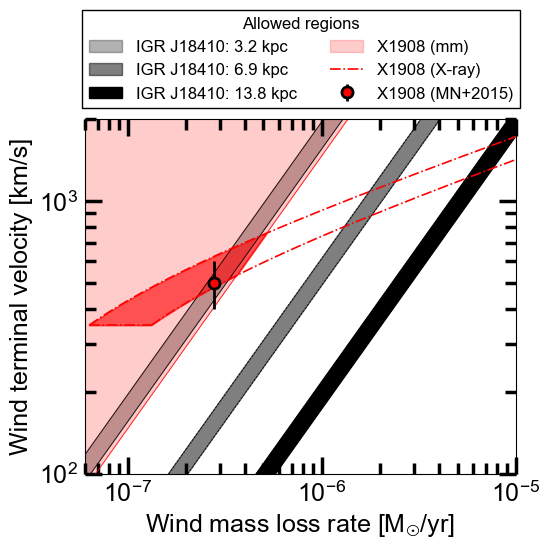

In [33]:
##### Setting up the Figure and axes ######

fig = plt.figure(figsize=(cm2inch(1.6*single_col),cm2inch(1.6*single_col)))
ax = fig.add_subplot(111)

ax.tick_params(labelsize=LS, width=2.5, length=12, axis='both', which='major', pad=5)
ax.tick_params(labelsize=LS, length=8, width=2.5, axis='both', which='minor', pad=5)

ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.get_yaxis().set_tick_params(direction='in', which='both')
ax.get_xaxis().set_tick_params(direction='in', which='both')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(6e-8,1e-5)
ax.set_ylim(100, 2e3)
ax.set_xlabel('Wind mass loss rate [$M_{\odot}$/yr]', fontsize=FS)
ax.set_ylabel(r'Wind terminal velocity [km/s]', fontsize=FS)

##### The constraints for the SFXT #####

# For each distance, plot the edges and fill the region enclosed by them. 
ax.fill_between(mdot_axis.value, v_SFXT_m_low.value, v_SFXT_p_low.value, color='k', alpha=0.3, 
                label=r'IGR J18410: 3.2 kpc')
ax.plot(mdot_axis, v_SFXT_m_low, 'k-', lw=0.5)
ax.plot(mdot_axis, v_SFXT_p_low, 'k-', lw=0.5)

ax.fill_between(mdot_axis.value, v_SFXT_m_medium.value, v_SFXT_p_medium.value, color='k', alpha=0.5, 
                label=r'IGR J18410: 6.9 kpc')
ax.plot(mdot_axis, v_SFXT_m_medium, 'k--', lw=0.5)
ax.plot(mdot_axis, v_SFXT_p_medium, 'k--', lw=0.5)

ax.fill_between(mdot_axis.value, v_SFXT_m_high.value, v_SFXT_p_high.value, color='k', alpha=1., 
                label=r'IGR J18410: 13.8 kpc')
ax.plot(mdot_axis, v_SFXT_m_high, 'k--', lw=0.5)
ax.plot(mdot_axis, v_SFXT_p_high, 'k--', lw=0.5)

##### The constraints for the SgXB #####

# The mm constraints:
ax.fill_between(mdot_axis.value, v_SgXB, [1e5]*len(v_SgXB), color='r', alpha=0.2, label='X1908 (mm)')
ax.plot(mdot_axis, v_SgXB, 'r', lw=0.5)

# The edges of the X-rays constraints, not plotting below the orbital velocity:
ax.plot(mdot_axis[450:], v_acc_SgXB_min[450:], 'r-.', lw=1.2, label='X1908 (X-ray)')
ax.plot(mdot_axis[530:], v_acc_SgXB_max[530:], 'r-.', lw=1.2)
ax.plot([mdot_axis[450].value ,mdot_axis[530].value], [350, 350], 'r-.', lw=1.2)

# Filling the overlap between the X-ray and mm regions:
max_comp = np.maximum(v_acc_SgXB_max.value, v_SgXB.value)
max_comp = np.maximum(max_comp, 350.)
ax.fill_between(mdot_axis.value, max_comp, v_acc_SgXB_min.value, 
                where=(v_acc_SgXB_min.value > max_comp), color='r', alpha=0.6)

##### Plotting the data point from Martinez-Nunez et al. (2015) #####

ax.errorbar(2.8e-7, 500, yerr=100, fmt='ro', mec='k', mew=2, elinewidth=2, ecolor='k', ms=8, zorder=10, 
            label='X1908 (MN+2015)')

##### Adding the legend above the figure #####

leg = ax.legend(loc=(-0.005, 1.03), frameon=True, fontsize=FS-6, framealpha=1, fancybox=False, ncol=2, 
                title='Allowed regions', title_fontsize=FS-6)
frame = leg.get_frame()
frame.set_edgecolor('k')

plt.tight_layout()
plt.savefig('Figure1.pdf')

# Calculating the lower limit on spectral index $\alpha$

The idea of this calculation follows Van den Eijnden et al. (2021; https://arxiv.org/pdf/2107.05286.pdf). The data is as follows:
- a 3-sigma upper limit at low frequency
- a significant detection at high frequency

For a spectral index $\alpha$, we can wonder: given the high-frequency detection, what is the probability that we would have obtained a detection at low frequency? For an error-less measurement at high frequency, we could analytically calculate this probability as a function of $\alpha$, and derive where it crosses our desired confidence level. 

In reality, however, the high-frequency detection comes with an uncertainty. Therefore, for each $\alpha_i$ in a grid of $\alpha$s, we will repeat the following steps:
1) draw $10^5$ values of the high-frequency flux density from a normal distribution around the measured flux density, with standard deviation equal to the high-frequency image RMS. 
2) calculate the inferred low-frequency flux density for each of the drawn high-frequency, assuming a spectral index $\alpha_i$. 
3) calculate the fraction of the $10^5$ trials where the low-frequency flux density would not have been detected, at whatever detection treshold is used in the real analysis. 

Here, our detection treshold is an ATCA flux density exceeding $3\times16 = 48$ $\mu$Jy. 

We finally search for the value of $\alpha$ where the probability of non-detection exceeds the one-sided $3$-$\sigma$ level, i.e. $P_{\rm non-det} \geq 2.699796\times10^{-3}$. 

In other words, at any lower value of $\alpha$, the probability of the obtained result (a non-detection) would have been too small (compared to our desired threshold level) to attribute to stochatics.

### Defining the grid in spectral index

In [18]:
alpha_grid = list(np.linspace(-0.25, 0.5, 201, endpoint=True))

### Defining the flux densities, sensitivities, and frequencies:

In [19]:
# Band with the detection: we assume this is the upper frequency
flux = 63.4
dflux = 9.6 

# Band without the detection: we assume this is the low frequency
rms = 16. # lower frequency band

F1 = 7.25 # Non-detection band: low freq in GHz
F2 = 100. # Detection band: high freq in GHz

### Calculating the probabilities

In [20]:
prob = []
N = 100000 
for alpha in alpha_grid:
    M = 0
    i = 0

    # we only counts trials where the simulated detected flux density is positive:
    while i < N:
        sim1 = np.random.normal(flux, dflux) # the drawn flux density at the upper frequency
        sim2 = sim1*((F1/F2)**alpha) # the calculated, corresponding, lower-frequency flux density
        
        if sim1 > 0: # ensuring positive flux densities
            i = i+1
        
            if sim2 <= 3*rms:
                M = M+1

    prob.append(float(M)/float(N))

In [21]:
treshold = 1-0.997300203936740 # 3 sigma one-sided

In [22]:
would_be_detected = []
for i in range(len(prob)):
    if prob[i] >= treshold:
        would_be_detected.append(alpha_grid[i])
limit = min(would_be_detected)

print(r'alpha > '+str(limit)+' at 3-sigma significance')

alpha > -0.1 at 3-sigma significance


### Plotting

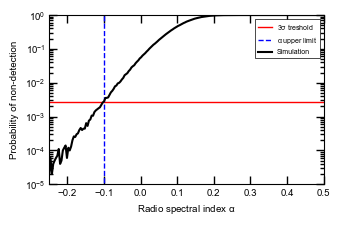

In [23]:
fig = plt.figure(figsize=(cm2inch(single_col),cm2inch(6)))
ax = fig.add_subplot(111)

FS = 7
LS = 7
MS = 3
MEW=0.75
ax.tick_params(labelsize=LS, width=1, length=6, axis='both', which='major', pad=3)
ax.tick_params(labelsize=LS, length=3, width=1, axis='both', which='minor', pad=3)
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.get_yaxis().set_tick_params(direction='in', which='both')
ax.get_xaxis().set_tick_params(direction='in', which='both')

ax.set_xlabel(r'Radio spectral index $\alpha$', fontsize=FS)
ax.set_ylabel(r'Probability of non-detection', fontsize=FS)

ax.plot([-100, 100], [treshold, treshold], 'r-', lw=1, label=r'$3\sigma$ treshold')
ax.plot([limit, limit], [-100, 100], 'b--', lw=1, label=r'$\alpha$ upper limit')
ax.plot(alpha_grid, prob, 'k-', lw=1.5, label='Simulation')

ax.set_xlim(-0.25, 0.5)
ax.set_ylim(1e-5, 1.0)

ax.set_yscale('log')

leg = ax.legend(loc=1, frameon=True, fontsize=5, ncol=1, numpoints=1, fancybox=False, framealpha=1.0)
leg.get_frame().set_edgecolor('k')
leg.get_frame().set_linewidth(0.5)

plt.tight_layout()
plt.savefig('UL_SFXT_submm.pdf')